# Time Series forecasting fundamentals with tensorflow + Milestone projet 3: BitPredict

Time series problems deal with data over time.

https://otexts.com/fpp3/

https://www.uber.com/en-FR/blog/forecasting-introduction/

<img src="course_images/10_time_series/10-example-time-series-problems.png" height="500">

<img src="course_images/10_time_series/time_series_inputs_and_outputs.png" height="500">

<img src="course_images/10_time_series/bitpredict_input_and_output_shape.png" height="500">

Let's write some Tensorflow code to predict the price of Bitcoin based on the historical price of Bitcoin

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin


https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

## importing time series pandas

In [20]:
# import with pandas
import pandas as pd
# read in our Bitcoin data and parse the dates
df = pd.read_csv("data/time_series/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas column 1 is a datetime

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [22]:
# how many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> 🔑 **Note** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

<img src="course_images/10_time_series/10-types-of-time-series-patterns.png" height="500">

<img src="course_images/10_time_series/univariate_and_multivariate_time_series_data.png" height="500">

In [23]:
# only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


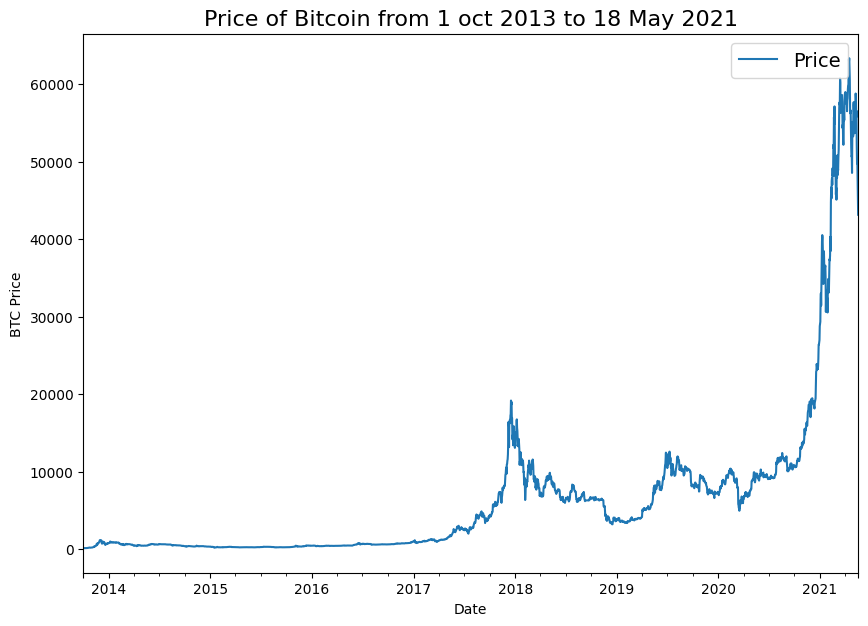

In [24]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)

## Importing time series data with Python's CSV module

In [25]:
# importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("./data/time_series/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    next(csv_reader) # skip first line (this gets rid of the column titles (header))
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
        btc_price.append(float(line[2])) # get the closing price as float

# viex first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

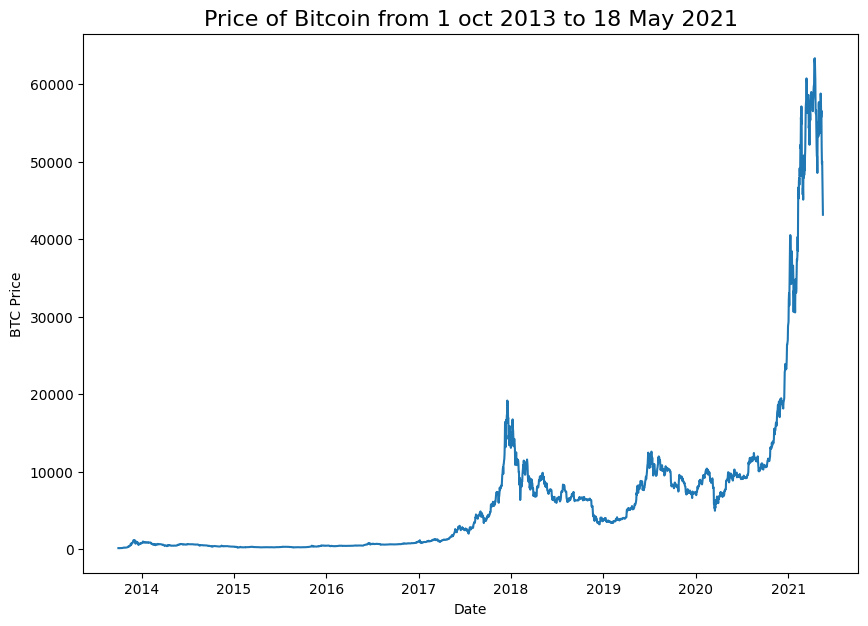

In [26]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [27]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [28]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, #dates
                                                    prices, # BTC prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test

((2229,),
 (558,),
 (2229,),
 array([ 7954.00623772, 56427.04312502,  4186.78374   ,  9906.40796505,
        10983.21600203,   618.79      ,  9737.45855879,   519.015     ,
        11452.23      ,   602.4075    ,  1004.71375   ,   705.47125   ,
          277.853     ,   264.98625   ,  9917.24841434, 11261.80633174,
        15632.41125   ,   509.70665   ,   332.471     ,   445.327     ,
        10272.9025    , 11833.8973487 ,  3782.66410112, 10381.85595925,
         6396.35212354,  6280.31010688, 11742.94125   ,   407.473     ,
        10551.13163333,  1245.892     ,  3763.6205158 ,   238.06125   ,
        11802.95996359,   270.07587   , 10367.52799811,   609.495     ,
        47500.8975242 ,   455.28316   ,   304.9905    ,   620.59875   ,
          226.30419   , 10818.50700762, 29111.52156712, 56300.33410863,
          349.138     ,   728.36125   ,   644.091     ,   637.01625   ,
          511.4725    ,   376.59      ,  1196.896     ,   414.458     ,
          443.681     , 11358.70637

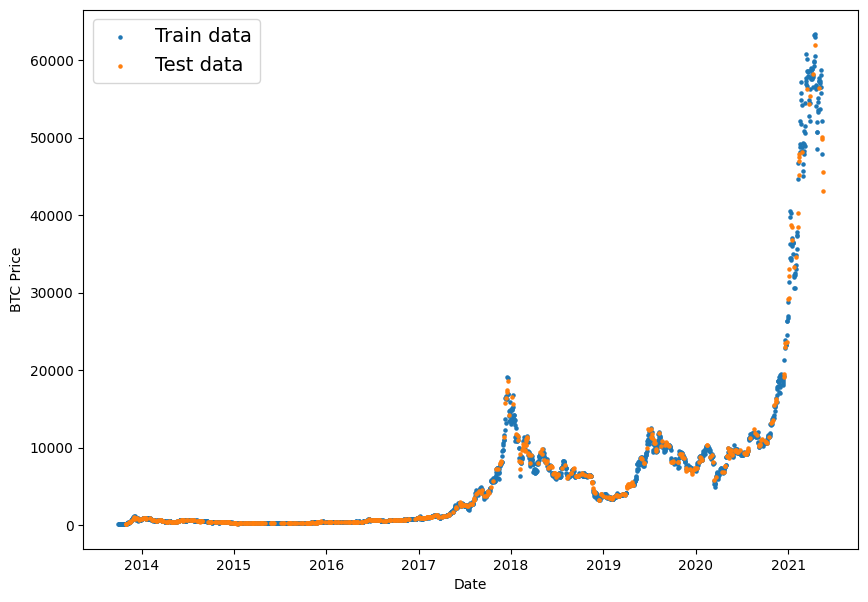

In [29]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

<img src="course_images/10_time_series/time_series_train_and_sets.png" height="500">

### Create train and test sets for time series (the right way)

In [30]:
# create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed (eg. 90/10, 95/5)

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

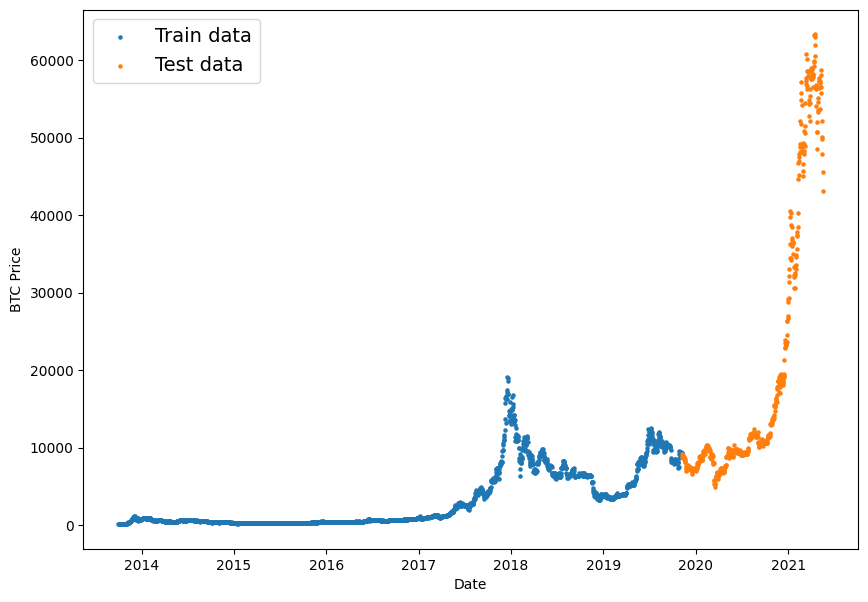

In [31]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it

In [32]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values ( a series of values across timesteps)

    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values accross time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end: where to end the plot
    label : label to show on plot about values, default None
    """
    # Plot series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

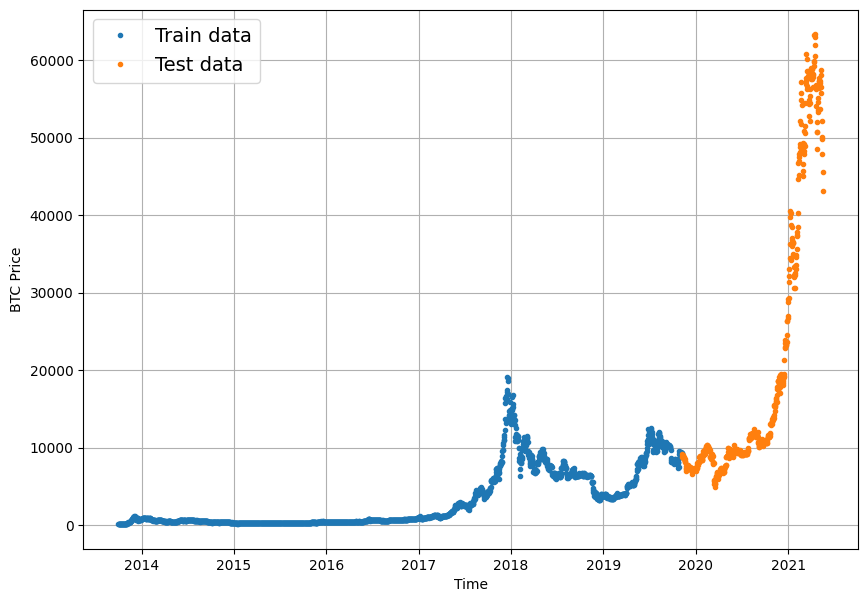

In [33]:
# Test out plotting function
plt.figure(figsize=(10,7)) # we create 1 figure, then we add 2 plot
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which performs the best.

* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 0 	Naïve model (baseline)
* 1 	Dense model, window = 1, horizon = 7
* 2 	Same as 1, window = 30, horizon= 1
* 3 	Same as 1, window = 30, horizon= 7
* 4 	Conv1D
* 5 	LSTM
* 6 	Same as 1 (but with multivariate data)
* 7 	N-BEATs Algorithm
* 8 	Ensemble (multiple models optimized on different loss functions)
* 9 	Future prediction model (model to predict future values)
* 10 	Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [34]:
# Create a native forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

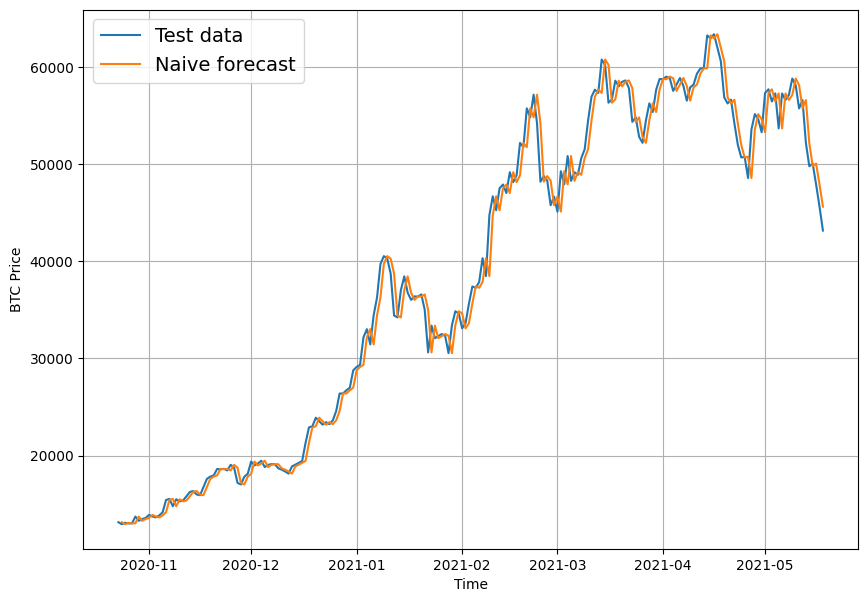

In [35]:
plt.figure(figsize=(10,7)) # we create 1 figure, then we add 2 plot
#plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicating a number, so that means we have a fomr of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* **MAE** - mean absolute error
* **MSE** - mean squarred error
* **RMSE** - root mean square error
* **MAPE/sMAPE** - (symmetric) mean absolute percentage error
* **MASE** - mean absolute scaled error

For all of the above metrics, **lower is better**

📖 https://otexts.com/fpp3/accuracy.html

<img src="course_images/10_time_series/commons_time_series_evaluation_metrics.png" height="500">

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

In [36]:
import tensorflow as tf

In [37]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true-y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

    return mae / mae_naive_no_season

In [38]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182626

In [39]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
    }


In [40]:
naive_resuts = evaluate_preds(y_true=y_test[1:],
                              y_pred=naive_forecast)
naive_resuts

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecating models you may want to experiment with:

https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts


## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [41]:
len(y_train)

2229

In [42]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}") 

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [43]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [44]:
# Create function de label windowed data
def get_labelled_windows(x, horizon=HORIZON):
    """
    creates label for windowed dataset.

    E.g if Horizon=1
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [45]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


<img src="course_images/10_time_series/10-time-series-windows-and-horizons.png" height="500">

<img src="http://eng.uber.com/wp-content/uploads/2018/09/image6-e1536165830511.png?uclick_id=4cf2e7cd-e97f-42c9-bf37-d6e6cea5531a" height="500">


We've got a way to label our windowed data.

However, this only work on a small scale.

We need a way to do the above accros our entire time series.

We could do this with Python for loops, however , for large time series, that'd be quite slow.

To speed things up, we'll leverage Numpy's array indexing. - https://numpy.org/doc/stable/user/arrays.indexing.html

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:

```
[[0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

> 📖 **Resource**: The function we're about to create has been adapted from the following article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [46]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D aray into a 2D array of sequential labelled windows of window_size with horizon size labels.
    """
    # 1. Create a window of a specific windows_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

    # 2. Create a 2D array of multiple window steps ( minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # Create a 2D array of windows of size window_size
    #print(f"window indexes:\n {window_indexes, window_indexes.shape}")

    # 3. Index on the target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    #print(windowed_array)

    # 4. Get the labelles windows
    windows, labels = get_labelled_windows(windowed_array, horizon=HORIZON)
    return windows, labels


In [47]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [48]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [49]:
# View the last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


🔑 **Note**: There is a function which does similar to the above in tf.keras.preprocessing, an extension could be try and replicate what w've done using the premade function.

https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning windows into training and test sets

In [50]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [51]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [52]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [53]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For exmaple if our model performs the best on epoech 55 (but we're train for 100 epochs), we want to lad and evaluate the model saved on epoch 55.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [54]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        monitor="val_loss",
        verbose=0, # only output a limited amount of text
        save_best_only=True
    )

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values ?

Experimentation.

* **Hyperparameters** = values a machine learning practitioner can adjust themselves
* **Parameters** = values a model learns on its own

In [60]:
import tensorflow as tf
import keras
from keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear") # linear = same output as before last output(same as having no activation)
], name="model_1_dense")

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128, # adjustable acconrding to the size of our sample (for 1 image, it is big, for us we have windows of 7 ())
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 4s - loss: 3685.9885 - mae: 3685.9885 - mse: 27989426.0000INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 21ms/step - loss: 1811.7632 - mae: 1811.7632 - mse: 10062284.0000 - val_loss: 1154.6702 - val_mae: 1154.6702 - val_mse: 4355303.0000
Epoch 2/100
18/18 [==============================] - 0s 2ms/step - loss: 383.2816 - mae: 383.2816 - mse: 577087.8750 - val_loss: 1822.0688 - val_mae: 1822.0688 - val_mse: 8037516.0000
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 248.8190 - mae: 248.8190 - mse: 295958.0938 - val_loss: 1165.9481 - val_mae: 1165.9481 - val_mse: 4351875.5000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 259.7439 - mae: 259.7439 - mse: 327912.6875INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 210.2813 - mae: 210.2813 - mse: 221503.6875 - val_loss: 1081.6992 - val_mae: 1081.6992 - val_mse: 3929992.2500
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 215.0387 - mae: 215.0387 - mse: 166646.0781INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 193.9089 - mae: 193.9089 - mse: 198442.8750 - val_loss: 1071.7445 - val_mae: 1071.7445 - val_mse: 3628757.7500
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 140.5347 - mae: 140.5347 - mse: 68007.0469INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 184.5891 - mae: 184.5891 - mse: 180520.5469 - val_loss: 1024.8417 - val_mae: 1024.8417 - val_mse: 3514893.0000
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 219.1191 - mae: 219.1191 - mse: 341390.4375INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 179.8233 - mae: 179.8233 - mse: 172650.7500 - val_loss: 993.0028 - val_mae: 993.0028 - val_mse: 3216213.7500
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 148.7354 - mae: 148.7354 - mse: 84355.2500INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 175.0448 - mae: 175.0448 - mse: 163421.2969 - val_loss: 972.7911 - val_mae: 972.7911 - val_mse: 3063384.0000
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 146.6941 - mae: 146.6941 - mse: 100716.6484INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 169.9082 - mae: 169.9082 - mse: 157090.2812 - val_loss: 956.8207 - val_mae: 956.8207 - val_mse: 2925805.5000
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 179.9576 - mae: 179.9576 - mse: 233700.7812INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 32ms/step - loss: 165.6996 - mae: 165.6996 - mse: 150318.7969 - val_loss: 913.4056 - val_mae: 913.4056 - val_mse: 2740199.2500
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 178.5953 - mae: 178.5953 - mse: 133054.1875INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 160.2347 - mae: 160.2347 - mse: 140771.5469 - val_loss: 886.6426 - val_mae: 886.6426 - val_mse: 2598246.2500
Epoch 12/100
18/18 [==============================] - 0s 2ms/step - loss: 155.8952 - mae: 155.8952 - mse: 134220.6094 - val_loss: 930.8119 - val_mae: 930.8119 - val_mse: 2617148.2500
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 121.0755 - mae: 121.0755 - mse: 96917.0938INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 152.6966 - mae: 152.6966 - mse: 130788.1719 - val_loss: 875.8814 - val_mae: 875.8813 - val_mse: 2398898.2500
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 154.9290 - mae: 154.9290 - mse: 107383.6719INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 148.0710 - mae: 148.0710 - mse: 122625.2656 - val_loss: 874.3804 - val_mae: 874.3804 - val_mse: 2338072.7500
Epoch 15/100
18/18 [==============================] - 0s 2ms/step - loss: 146.2817 - mae: 146.2817 - mse: 119811.0781 - val_loss: 887.6529 - val_mae: 887.6529 - val_mse: 2334115.0000
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 134.0840 - mae: 134.0840 - mse: 75735.3203INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 146.7579 - mae: 146.7579 - mse: 119648.4844 - val_loss: 799.5129 - val_mae: 799.5129 - val_mse: 2038517.0000
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 132.0026 - mae: 132.0026 - mse: 83116.7031INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 141.2719 - mae: 141.2719 - mse: 111126.4844 - val_loss: 787.4595 - val_mae: 787.4595 - val_mse: 1968821.3750
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 147.9748 - mae: 147.9748 - mse: 120365.3672INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 136.9028 - mae: 136.9028 - mse: 107484.9219 - val_loss: 777.2802 - val_mae: 777.2802 - val_mse: 1907290.8750
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 77.9394 - mae: 77.9394 - mse: 31560.6562INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 132.7454 - mae: 132.7454 - mse: 102985.5859 - val_loss: 762.0865 - val_mae: 762.0865 - val_mse: 1840554.8750
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 140.5202 - mae: 140.5202 - mse: 123278.0469INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 133.6851 - mae: 133.6851 - mse: 104311.1094 - val_loss: 734.1791 - val_mae: 734.1791 - val_mse: 1773628.3750
Epoch 21/100
18/18 [==============================] - 0s 2ms/step - loss: 133.8133 - mae: 133.8133 - mse: 103516.5078 - val_loss: 775.5758 - val_mae: 775.5758 - val_mse: 1835941.0000
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 177.7390 - mae: 177.7390 - mse: 168946.5625INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 127.6149 - mae: 127.6149 - mse: 95665.0234 - val_loss: 733.1298 - val_mae: 733.1298 - val_mse: 1703332.8750
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 127.1851 - mae: 127.1851 - mse: 75617.9219INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 17ms/step - loss: 126.6244 - mae: 126.6244 - mse: 93797.1094 - val_loss: 703.2138 - val_mae: 703.2138 - val_mse: 1633333.1250
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 136.9532 - mae: 136.9532 - mse: 92426.1719INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 17ms/step - loss: 125.5104 - mae: 125.5104 - mse: 93699.5312 - val_loss: 700.5935 - val_mae: 700.5935 - val_mse: 1657504.0000
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 124.5635 - mae: 124.5635 - mse: 59037.9883INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 124.7057 - mae: 124.7057 - mse: 90553.4297 - val_loss: 691.1508 - val_mae: 691.1508 - val_mse: 1618815.1250
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 126.4129 - mae: 126.4129 - mse: 73505.3750INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 17ms/step - loss: 123.6687 - mae: 123.6687 - mse: 90049.2656 - val_loss: 682.6912 - val_mae: 682.6912 - val_mse: 1542793.8750
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 172.7239 - mae: 172.7239 - mse: 143314.5625INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 123.1264 - mae: 123.1264 - mse: 88115.9531 - val_loss: 672.9219 - val_mae: 672.9219 - val_mse: 1531263.2500
Epoch 28/100
18/18 [==============================] - 0s 2ms/step - loss: 120.3648 - mae: 120.3648 - mse: 85943.4844 - val_loss: 679.4329 - val_mae: 679.4329 - val_mse: 1506963.7500
Epoch 29/100
18/18 [==============================] - 0s 2ms/step - loss: 121.7748 - mae: 121.7748 - mse: 87342.9922 - val_loss: 687.1258 - val_mae: 687.1258 - val_mse: 1513955.6250
Epoch 30/100
18/18 [==============================] - 0s 2ms/step - loss: 123.6192 - mae: 123.6192 - mse: 87153.4688 - val_loss: 675.1949 - val_mae: 675.1949 - val_mse: 1481120.2500
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 126.7430 - mae: 126.7430 - mse: 77386.6016INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 118.7407 - mae: 118.7407 - mse: 82393.4922 - val_loss: 670.2842 - val_mae: 670.2842 - val_mse: 1463714.7500
Epoch 32/100
18/18 [==============================] - 0s 2ms/step - loss: 118.3516 - mae: 118.3516 - mse: 84776.5703 - val_loss: 670.7101 - val_mae: 670.7101 - val_mse: 1459686.2500
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 149.2974 - mae: 149.2974 - mse: 146669.7812INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 116.7467 - mae: 116.7467 - mse: 81220.2031 - val_loss: 658.3109 - val_mae: 658.3109 - val_mse: 1425415.6250
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 142.0041 - mae: 142.0041 - mse: 151256.5625INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 117.1821 - mae: 117.1821 - mse: 83344.2578 - val_loss: 640.9219 - val_mae: 640.9219 - val_mse: 1385299.2500
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 103.1234 - mae: 103.1234 - mse: 53556.3203INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 116.3633 - mae: 116.3633 - mse: 82554.0781 - val_loss: 629.2798 - val_mae: 629.2798 - val_mse: 1375524.7500
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 153.5754 - mae: 153.5754 - mse: 157332.1094INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 117.0173 - mae: 117.0173 - mse: 81344.3438 - val_loss: 625.6711 - val_mae: 625.6711 - val_mse: 1362086.0000
Epoch 37/100
18/18 [==============================] - 0s 2ms/step - loss: 114.7936 - mae: 114.7936 - mse: 81280.1016 - val_loss: 634.2213 - val_mae: 634.2213 - val_mse: 1356039.3750
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 105.0638 - mae: 105.0638 - mse: 70893.5781INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 114.6934 - mae: 114.6934 - mse: 80167.7578 - val_loss: 621.1597 - val_mae: 621.1597 - val_mse: 1334633.6250
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 134.7930 - mae: 134.7930 - mse: 116762.2734INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 115.1484 - mae: 115.1484 - mse: 80834.2031 - val_loss: 618.2743 - val_mae: 618.2743 - val_mse: 1339906.1250
Epoch 40/100
18/18 [==============================] - 0s 2ms/step - loss: 113.3458 - mae: 113.3458 - mse: 78008.5391 - val_loss: 638.6081 - val_mae: 638.6081 - val_mse: 1408613.8750
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 116.1841 - mae: 116.1841 - mse: 61522.2578INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 113.5818 - mae: 113.5818 - mse: 79420.8984 - val_loss: 611.9984 - val_mae: 611.9984 - val_mse: 1317916.5000
Epoch 42/100
18/18 [==============================] - 0s 2ms/step - loss: 117.7449 - mae: 117.7449 - mse: 82586.8594 - val_loss: 688.3359 - val_mae: 688.3359 - val_mse: 1461298.3750
Epoch 43/100
18/18 [==============================] - 0s 2ms/step - loss: 122.0164 - mae: 122.0164 - mse: 82214.1719 - val_loss: 618.7103 - val_mae: 618.7103 - val_mse: 1340746.8750
Epoch 44/100
18/18 [==============================] - 0s 2ms/step - loss: 119.8184 - mae: 119.8184 - mse: 83554.0859 - val_loss: 643.6295 - val_mae: 643.6295 - val_mse: 1407922.3750
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 87.2897 - mae: 87.2897 - mse: 41257.6172INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 17ms/step - loss: 111.3100 - mae: 111.3100 - mse: 77562.7656 - val_loss: 608.9788 - val_mae: 608.9788 - val_mse: 1288714.8750
Epoch 46/100
18/18 [==============================] - 0s 3ms/step - loss: 113.2885 - mae: 113.2885 - mse: 76831.3984 - val_loss: 617.4509 - val_mae: 617.4509 - val_mse: 1332390.6250
Epoch 47/100
18/18 [==============================] - 0s 2ms/step - loss: 115.0751 - mae: 115.0751 - mse: 79886.0469 - val_loss: 752.2628 - val_mae: 752.2628 - val_mse: 1629362.3750
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 124.4726 - mae: 124.4726 - mse: 74435.4375INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 17ms/step - loss: 113.8738 - mae: 113.8738 - mse: 76710.1328 - val_loss: 608.8087 - val_mae: 608.8087 - val_mse: 1277829.5000
Epoch 49/100
18/18 [==============================] - 0s 3ms/step - loss: 112.4729 - mae: 112.4729 - mse: 76974.6875 - val_loss: 626.4296 - val_mae: 626.4296 - val_mse: 1308328.0000
Epoch 50/100
18/18 [==============================] - 0s 2ms/step - loss: 114.1525 - mae: 114.1525 - mse: 77435.4141 - val_loss: 684.9925 - val_mae: 684.9925 - val_mse: 1503681.7500
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 99.7817 - mae: 99.7817 - mse: 52828.4883INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 114.0765 - mae: 114.0765 - mse: 77860.0000 - val_loss: 602.2722 - val_mae: 602.2722 - val_mse: 1263955.3750
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - loss: 119.4679 - mae: 119.4679 - mse: 60973.8398INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 31ms/step - loss: 111.2808 - mae: 111.2808 - mse: 76224.3672 - val_loss: 596.7976 - val_mae: 596.7976 - val_mse: 1257522.6250
Epoch 53/100
18/18 [==============================] - 0s 2ms/step - loss: 113.5431 - mae: 113.5431 - mse: 78186.6328 - val_loss: 643.3171 - val_mae: 643.3171 - val_mse: 1338132.2500
Epoch 54/100
18/18 [==============================] - 0s 2ms/step - loss: 119.9173 - mae: 119.9173 - mse: 81493.6484 - val_loss: 793.2266 - val_mae: 793.2266 - val_mse: 1750683.2500
Epoch 55/100
18/18 [==============================] - 0s 3ms/step - loss: 119.9198 - mae: 119.9198 - mse: 79513.3359 - val_loss: 606.6982 - val_mae: 606.6982 - val_mse: 1291772.5000
Epoch 56/100
18/18 [==============================] - 0s 2ms/step - loss: 119.0272 - mae: 119.0272 - mse: 80645.2344 - val_loss: 949.0753 - val_mae: 949.0753 - val_mse: 2432225.5000
Epoch 57/100
18/18 [==============================] - 0s 2ms/step - loss: 142.3781 - mae: 142.3781 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 110.1533 - mae: 110.1533 - mse: 74470.8516 - val_loss: 596.6951 - val_mae: 596.6951 - val_mse: 1260060.7500
Epoch 63/100
18/18 [==============================] - 0s 2ms/step - loss: 113.0659 - mae: 113.0659 - mse: 76213.1875 - val_loss: 633.6843 - val_mae: 633.6843 - val_mse: 1308583.8750
Epoch 64/100
18/18 [==============================] - 0s 2ms/step - loss: 112.0783 - mae: 112.0783 - mse: 75200.1797 - val_loss: 659.6252 - val_mae: 659.6252 - val_mse: 1370213.8750
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 138.1789 - mae: 138.1789 - mse: 168044.8594INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 112.2888 - mae: 112.2888 - mse: 76160.3516 - val_loss: 587.2960 - val_mae: 587.2960 - val_mse: 1231733.6250
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 109.2482 - mae: 109.2482 - mse: 68012.8828INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 109.1011 - mae: 109.1011 - mse: 73233.6250 - val_loss: 586.1242 - val_mae: 586.1242 - val_mse: 1226708.0000
Epoch 67/100
18/18 [==============================] - 0s 2ms/step - loss: 109.1522 - mae: 109.1522 - mse: 73602.0938 - val_loss: 605.1920 - val_mae: 605.1920 - val_mse: 1277500.0000
Epoch 68/100
18/18 [==============================] - 0s 2ms/step - loss: 114.3720 - mae: 114.3720 - mse: 74069.2500 - val_loss: 669.7114 - val_mae: 669.7114 - val_mse: 1432942.0000
Epoch 69/100
18/18 [==============================] - 0s 2ms/step - loss: 127.6584 - mae: 127.6584 - mse: 84964.3203 - val_loss: 644.8826 - val_mae: 644.8826 - val_mse: 1368234.1250
Epoch 70/100
18/18 [==============================] - 0s 2ms/step - loss: 126.3781 - mae: 126.3781 - mse: 84906.1406 - val_loss: 612.7879 - val_mae: 612.7879 - val_mse: 1292240.2500
Epoch 71/100
18/18 [==============================] - 0s 2ms/step - loss: 113.4261 - mae: 113.4261 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 109.6506 - mae: 109.6506 - mse: 74391.4688 - val_loss: 585.0701 - val_mae: 585.0701 - val_mse: 1224530.7500
Epoch 73/100
18/18 [==============================] - 0s 2ms/step - loss: 111.7181 - mae: 111.7181 - mse: 74627.9609 - val_loss: 587.7884 - val_mae: 587.7884 - val_mse: 1231109.1250
Epoch 74/100
18/18 [==============================] - 0s 2ms/step - loss: 108.5202 - mae: 108.5202 - mse: 73295.8281 - val_loss: 587.1688 - val_mae: 587.1688 - val_mse: 1217147.6250
Epoch 75/100
18/18 [==============================] - 0s 2ms/step - loss: 109.9450 - mae: 109.9450 - mse: 72779.4844 - val_loss: 650.7306 - val_mae: 650.7306 - val_mse: 1344308.3750
Epoch 76/100
18/18 [==============================] - 0s 2ms/step - loss: 114.6070 - mae: 114.6070 - mse: 76527.5469 - val_loss: 590.4440 - val_mae: 590.4440 - val_mse: 1218117.3750
Epoch 77/100
18/18 [==============================] - 0s 2ms/step - loss: 114.1428 - mae: 114.1428 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 108.2160 - mae: 108.2160 - mse: 72535.1875 - val_loss: 583.3743 - val_mae: 583.3743 - val_mse: 1217084.3750
Epoch 79/100
18/18 [==============================] - 0s 2ms/step - loss: 108.7028 - mae: 108.7028 - mse: 73978.1016 - val_loss: 600.5505 - val_mae: 600.5505 - val_mse: 1257649.8750
Epoch 80/100
18/18 [==============================] - 0s 2ms/step - loss: 110.1221 - mae: 110.1221 - mse: 74431.2266 - val_loss: 584.9767 - val_mae: 584.9767 - val_mse: 1208928.5000
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 97.3245 - mae: 97.3245 - mse: 45500.4766INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 107.7609 - mae: 107.7609 - mse: 72404.5469 - val_loss: 580.3163 - val_mae: 580.3163 - val_mse: 1204376.0000
Epoch 82/100
18/18 [==============================] - 0s 2ms/step - loss: 117.8021 - mae: 117.8021 - mse: 80170.8906 - val_loss: 583.7023 - val_mae: 583.7023 - val_mse: 1216355.1250
Epoch 83/100
18/18 [==============================] - 0s 3ms/step - loss: 111.3801 - mae: 111.3801 - mse: 75259.6094 - val_loss: 630.3975 - val_mae: 630.3975 - val_mse: 1322291.8750
Epoch 84/100
 1/18 [>.............................] - ETA: 0s - loss: 118.7003 - mae: 118.7003 - mse: 89099.9062INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 111.4778 - mae: 111.4778 - mse: 74292.9219 - val_loss: 579.6729 - val_mae: 579.6729 - val_mse: 1206179.8750
Epoch 85/100
18/18 [==============================] - 0s 2ms/step - loss: 108.2334 - mae: 108.2334 - mse: 72963.1875 - val_loss: 596.5995 - val_mae: 596.5995 - val_mse: 1222834.3750
Epoch 86/100
18/18 [==============================] - 0s 3ms/step - loss: 111.6819 - mae: 111.6819 - mse: 73796.7422 - val_loss: 624.3820 - val_mae: 624.3820 - val_mse: 1278928.3750
Epoch 87/100
18/18 [==============================] - 0s 2ms/step - loss: 109.3971 - mae: 109.3971 - mse: 70929.6484 - val_loss: 617.8447 - val_mae: 617.8447 - val_mse: 1291519.0000
Epoch 88/100
 1/18 [>.............................] - ETA: 0s - loss: 139.4194 - mae: 139.4194 - mse: 135265.0312INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 109.3986 - mae: 109.3986 - mse: 74229.4531 - val_loss: 578.2715 - val_mae: 578.2715 - val_mse: 1201332.3750
Epoch 89/100
18/18 [==============================] - 0s 2ms/step - loss: 107.9138 - mae: 107.9138 - mse: 71636.3594 - val_loss: 578.6297 - val_mae: 578.6297 - val_mse: 1196137.3750
Epoch 90/100
18/18 [==============================] - 0s 2ms/step - loss: 109.3338 - mae: 109.3338 - mse: 69806.9609 - val_loss: 616.2625 - val_mae: 616.2625 - val_mse: 1261018.7500
Epoch 91/100
18/18 [==============================] - 0s 2ms/step - loss: 113.7524 - mae: 113.7524 - mse: 75374.1328 - val_loss: 624.0167 - val_mae: 624.0167 - val_mse: 1303926.7500
Epoch 92/100
18/18 [==============================] - 0s 2ms/step - loss: 109.1442 - mae: 109.1442 - mse: 73631.1172 - val_loss: 596.5850 - val_mae: 596.5850 - val_mse: 1243842.5000
Epoch 93/100
18/18 [==============================] - 0s 2ms/step - loss: 117.8476 - mae: 117.8476 - m

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 109.4841 - mae: 109.4841 - mse: 73863.7734 - val_loss: 576.2691 - val_mae: 576.2691 - val_mse: 1193961.2500
Epoch 98/100
18/18 [==============================] - 0s 2ms/step - loss: 108.5561 - mae: 108.5561 - mse: 72160.7812 - val_loss: 581.3466 - val_mae: 581.3466 - val_mse: 1207524.1250
Epoch 99/100
 1/18 [>.............................] - ETA: 0s - loss: 152.0486 - mae: 152.0486 - mse: 126883.1484INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 0s 16ms/step - loss: 107.4239 - mae: 107.4239 - mse: 72255.6016 - val_loss: 575.2185 - val_mae: 575.2185 - val_mse: 1189696.8750
Epoch 100/100
18/18 [==============================] - 0s 2ms/step - loss: 115.6240 - mae: 115.6240 - mse: 73892.5078 - val_loss: 642.6156 - val_mae: 642.6156 - val_mse: 1320858.0000


In [59]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 833us/step - loss: 565.2592 - mae: 565.2592 - mse: 1160714.2500


[565.2592163085938, 565.2592163085938, 1160714.25]

In [58]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 847us/step - loss: 565.2592 - mae: 565.2592 - mse: 1160714.2500


[565.2592163085938, 565.2592163085938, 1160714.25]

## Making forecats with a model (on the test dataset)

TO make "forecasts" on the test dataset (note: these wont't be actual forecats, they're only pseudo forecasts because actual forecats are into future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's predict() method
4. Returns the predictions

In [61]:
def make_preds(model, input_data):
    """
    Uses model to make predictions input_data.
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return !D array of predictions

In [64]:
# Make predictions using model_1 and see resuts
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 947us/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8768.06  , 8647.278 , 8910.259 , 8689.438 , 8608.427 , 8631.563 ,
        8610.342 , 8367.048 , 8377.939 , 8413.0205], dtype=float32)>)

In [68]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [69]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 642.61566,
 'mse': 1320858.4,
 'rmse': 1149.286,
 'mape': 2.9126258,
 'mase': 1.1288978}

In [70]:
naive_resuts

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

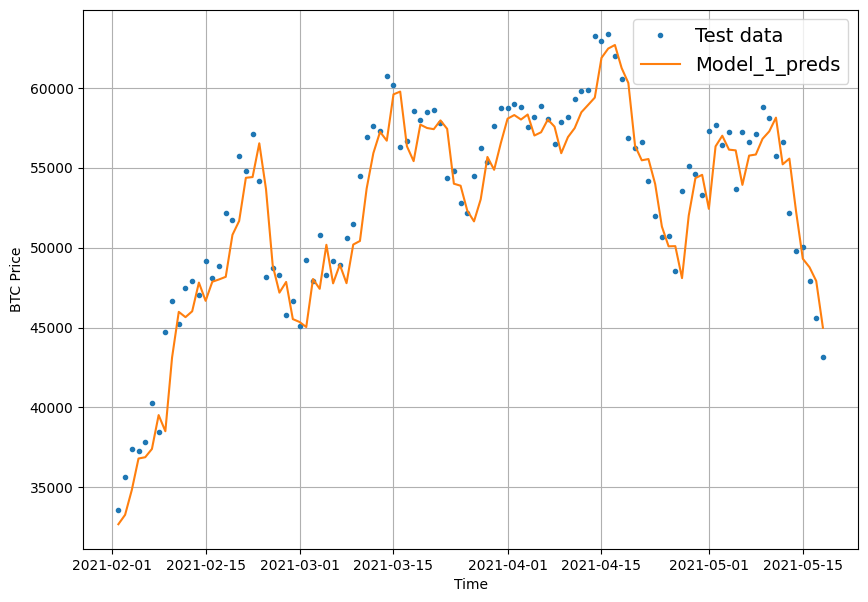

In [77]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=test_labels[:, 0],
    start=offset,
    label="Test data"
)

plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=model_1_preds,
    start=offset,
    format="-",
    label="Model_1_preds"
)